# Principal Component Analysis (PCA) on the Breast Cancer Dataset

This notebook demonstrates **Principal Component Analysis (PCA)** on the **Wisconsin Breast Cancer** dataset using your custom `pca` class (defined in `pca.py`).

PCA is an **unsupervised** technique that finds new axes (principal components) that:
- point in the directions of **maximum variance** in the data, and
- are **orthogonal** (uncorrelated) with each other.

Why do this?
- **Dimensionality reduction:** compress 30 features into fewer components
- **Visualization:** project high-dimensional data into 2D
- **Noise reduction:** keep the strongest patterns, drop small-variance directions
- **Preprocessing:** can improve speed/robustness for downstream models

In this notebook we will:
1. Fit PCA keeping **95% of the variance**
2. Visualize variance explained (**scree** + **cumulative** plots)
3. Visualize the data in **2D PCA space**
4. Inspect **feature loadings** (what drives PC1/PC2)
5. Quantify information loss using **reconstruction error**


## Imports

We use:
- `load_breast_cancer` from scikit-learn to get a clean, well-known dataset
- `pca` class for fitting, transforming, and inverse transforming



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer

from rice_ml.unsupervised_learning.pca import pca

# Make plots look nicer
plt.rcParams["figure.dpi"] = 120

## Load the Data

The Breast Cancer Wisconsin dataset contains measurements computed from digitized images of breast mass cell nuclei.

- **X** has shape `(n_samples, n_features)` and contains the numeric features
- **y** has shape `(n_samples,)` and contains the class label:
  - `0` = malignant
  - `1` = benign

Even though PCA is *unsupervised* (it does not use labels), we keep `y` so we can color points in plots
and see whether the PCA projection separates the two classes.


In [2]:
data = load_breast_cancer()
X = data.data
y = data.target
feature_names = data.feature_names
target_names = data.target_names

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Target names:", target_names)

X shape: (569, 30)
y shape: (569,)
Target names: ['malignant' 'benign']


## Fit PCA (retain 95% variance)

Here we choose `n_components=0.95`.

In your implementation, passing a float means:
> keep the **minimum number of components** such that the **cumulative explained variance** is at least that fraction.

So `0.95` means:
- PCA will pick **k** components (k is determined automatically)
- those k components explain **≥ 95%** of the total variance in the dataset

This is a practical way to reduce dimensionality without manually choosing k.


In [3]:
model = pca(n_components=0.95)
X_reduced = model.fit_transform(X)

print("Reduced shape:", X_reduced.shape)
print("Number of components retained:", model.n_components_)
print("Total explained variance:", model.explained_variance_ratio_.sum())

Reduced shape: (569, 10)
Number of components retained: 10
Total explained variance: 0.9515688143366668


## Visualization: Explained Variance (Scree Plot)

A **scree plot** shows the **explained variance ratio** for each principal component.

Interpretation tips:
- A very large bar for PC1 means most variation is captured by the first direction.
- If the bars drop quickly then level off, the “elbow” region often suggests a good k.
- Even if you keep many components, later components usually contribute only small amounts of variance.

This plot helps answer: **“Which components matter most?”**


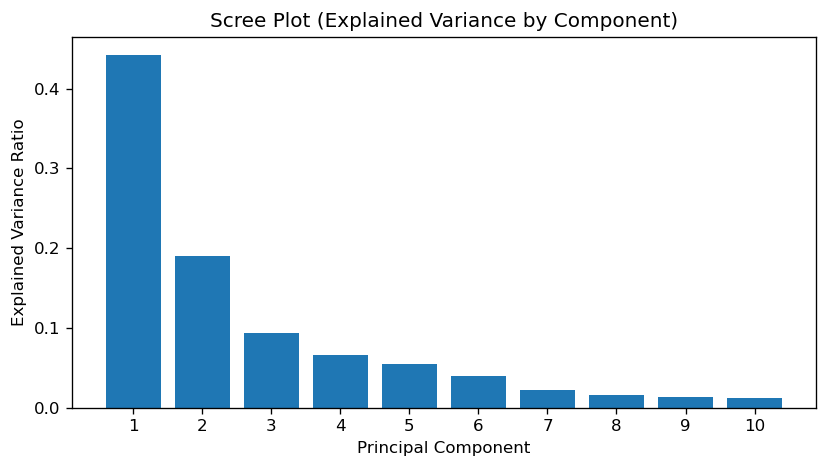

In [4]:
evr = model.explained_variance_ratio_
k = np.arange(1, len(evr) + 1)

plt.figure(figsize=(7, 4))
plt.bar(k, evr)
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("Scree Plot (Explained Variance by Component)")
plt.xticks(k)
plt.tight_layout()
plt.show()

## Visualization: Cumulative Explained Variance

This plot shows the **running total** of explained variance as we add more components.

Interpretation tips:
- Pick a target threshold like 90%, 95%, or 99%
- Read off the number of components needed to reach that threshold
- Diminishing returns: each extra component adds less and less explained variance

This plot helps answer: **“How many components do I need?”**


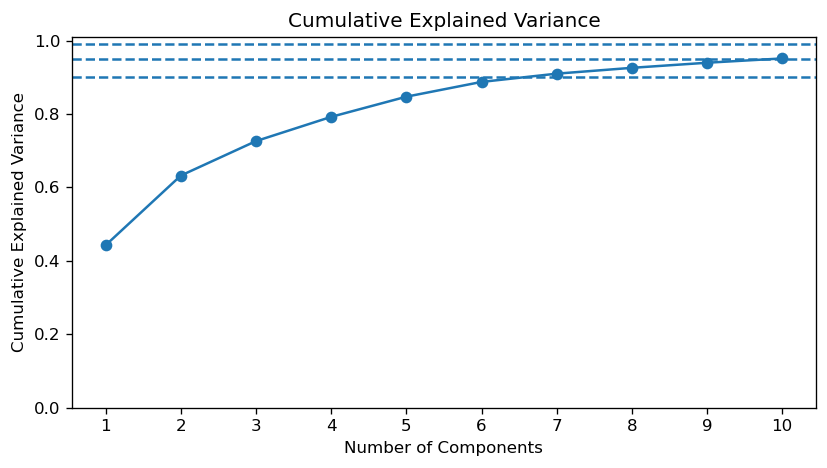

In [5]:
cum_evr = np.cumsum(evr)

plt.figure(figsize=(7, 4))
plt.plot(k, cum_evr, marker="o")
plt.axhline(0.90, linestyle="--")
plt.axhline(0.95, linestyle="--")
plt.axhline(0.99, linestyle="--")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Explained Variance")
plt.xticks(k)
plt.ylim(0, 1.01)
plt.tight_layout()
plt.show()

## Visualization: 2D PCA Projection (Colored by Class)

To visualize the data, we fit a *separate* PCA model with `n_components=2`.

Why a separate model?
- The 95% variance model may keep more than 2 components (k could be 8–12-ish)
- For plotting, we need exactly 2 columns (PC1 and PC2)

Even though PCA does not use labels, coloring by `y` helps us see:
- whether the dominant variance directions align with class separation, and
- how much overlap exists between malignant and benign samples in 2D.


In [6]:
pca_2d = pca(n_components=2)
X_2d = pca_2d.fit_transform(X)

print("2D shape:", X_2d.shape)

2D shape: (569, 2)


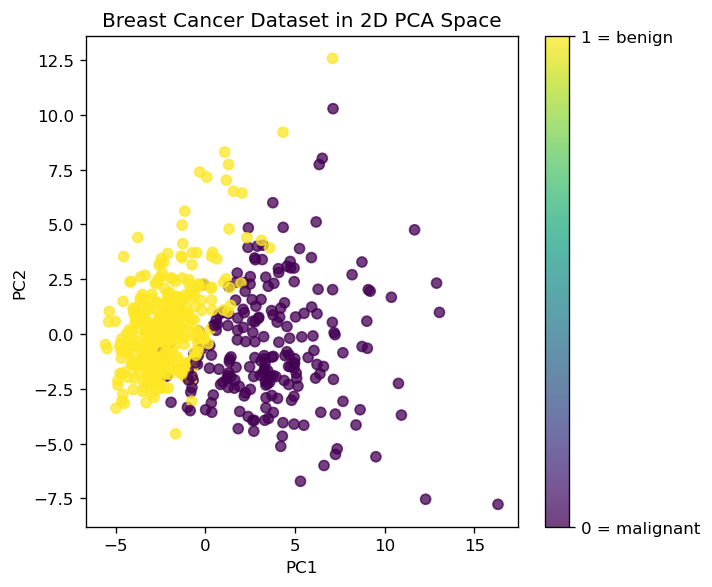

In [ ]:
plt.figure(figsize=(6, 5))
sc = plt.scatter(
    X_2d[:, 0],
    X_2d[:, 1],
    c=y,
    alpha=0.75,
)
plt.xlabel("Principle Component 1")
plt.ylabel("Principle Component 2")
plt.title("Breast Cancer Dataset in 2D PCA Space")

cbar = plt.colorbar(sc)
cbar.set_ticks([0, 1])
cbar.set_ticklabels([f"0 = {target_names[0]}", f"1 = {target_names[1]}"])

plt.tight_layout()
plt.show()

## Visualization: Class Centroids in PCA Space

A **centroid** is the mean position of a group of points.

Here we compute the centroid of each class in the 2D PCA space:
- one centroid for malignant samples
- one centroid for benign samples

If the centroids are far apart, it suggests that the PCA projection separates classes well.
If they overlap, the separation is weaker (at least along PC1/PC2).


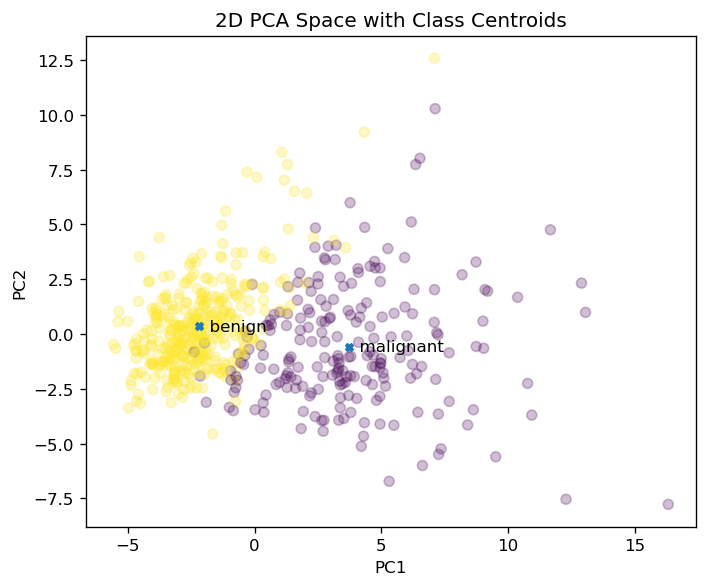

In [13]:
centroids = np.vstack([X_2d[y == cls].mean(axis=0) for cls in [0, 1]])

plt.figure(figsize=(6, 5))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y, alpha=0.25)
plt.scatter(centroids[:, 0], centroids[:, 1], s=20, marker="X")
for i, name in enumerate(target_names):
    plt.text(centroids[i, 0], centroids[i, 1], f"  {name}", va="center")

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2D PCA Space with Class Centroids")
plt.tight_layout()
plt.show()

## Feature Loadings for Principle Component 1 and Principle Component 2

Each principal component is a weighted combination of the original features.

Those weights are called **loadings**:
- A large **positive** loading means that feature increases as the component increases.
- A large **negative** loading means that feature decreases as the component increases.
- The **absolute value** indicates strength/importance for that component.

We display the **top 10 features by absolute loading** for Principle Component 1 and Principle Component 2.
This helps interpret what the axes “mean” in terms of original measurements.


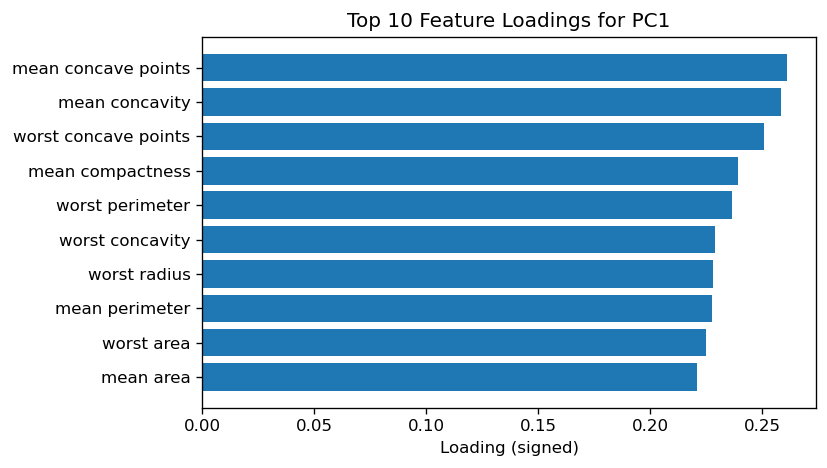

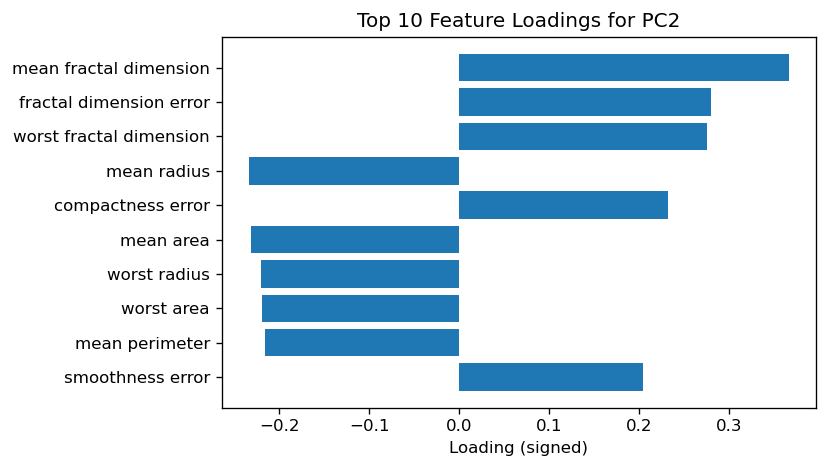

In [9]:
components = pca_2d.components_  # shape (2, n_features)

def top_loadings(component_vector, feature_names, top_n=10):
    idx = np.argsort(np.abs(component_vector))[::-1][:top_n]
    return idx, component_vector[idx]

for i in range(2):
    idx, vals = top_loadings(components[i], feature_names, top_n=10)
    plt.figure(figsize=(7, 4))
    plt.barh(np.arange(len(idx))[::-1], vals)
    plt.yticks(np.arange(len(idx))[::-1], feature_names[idx])
    plt.xlabel("Loading (signed)")
    plt.title(f"Top 10 Feature Loadings for PC{i+1}")
    plt.tight_layout()
    plt.show()

## Reconstruction and Information Loss

PCA can be viewed as a compression method:
1. **Transform:** map X → Z (lower-dimensional representation)
2. **Inverse transform:** map Z → X̂ (reconstruction in original feature space)

The difference between `X` and `X_hat` is what PCA cannot represent using the chosen number of components.

We quantify that loss with **mean squared error (MSE)**:
- smaller MSE = better reconstruction (less information lost)
- larger MSE = more information lost (more aggressive compression)


In [10]:
X_hat = model.inverse_transform(X_reduced)
reconstruction_mse = np.mean((X - X_hat) ** 2)
print("Reconstruction MSE (using 95% variance components):", reconstruction_mse)

Reconstruction MSE (using 95% variance components): 515.55815175695


## Visualization: Reconstruction Error vs Number of Components

This experiment makes the compression tradeoff very clear.

For k = 1, 2, ..., max_k:
- fit PCA with exactly k components
- reconstruct the data
- compute reconstruction MSE. The smaller the MSE, the better the reconstruction.

You should see a downward trend:
- small k → high error (too much information discarded)
- larger k → lower error (more information preserved)

This plot helps answer: **“How much error do I introduce by choosing k?”**


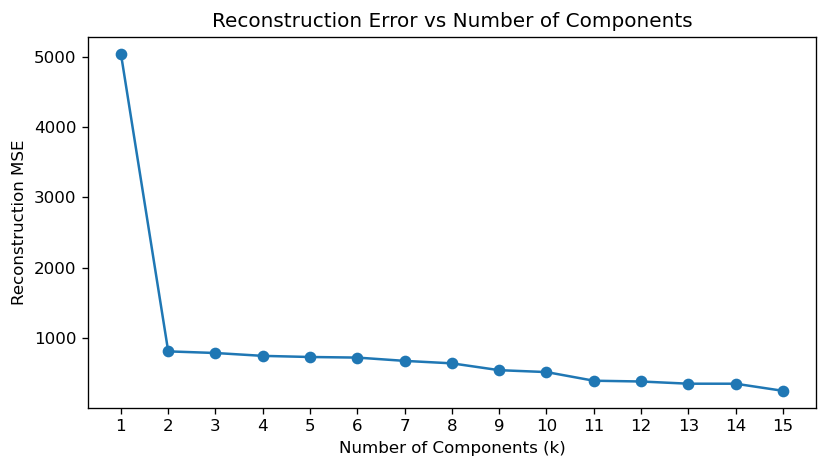

In [11]:
max_k = min(15, X.shape[1])  # keep this small so it runs fast
mses = []
ks = np.arange(1, max_k + 1)

for k in ks:
    m = pca(n_components=int(k))
    Z = m.fit_transform(X)
    X_rec = m.inverse_transform(Z)
    mses.append(np.mean((X - X_rec) ** 2))

plt.figure(figsize=(7, 4))
plt.plot(ks, mses, marker="o")
plt.xlabel("Number of Components (k)")
plt.ylabel("Reconstruction MSE")
plt.title("Reconstruction Error vs Number of Components")
plt.xticks(ks)
plt.tight_layout()
plt.show()

## Summary

What we learned from PCA on this dataset:

- The Breast Cancer dataset has **30 features**, but PCA can compress it to fewer dimensions while retaining most variance.
- The scree and cumulative variance plots help choose the number of components in a principled way.
- A **2D PCA projection** can already show meaningful structure and partial class separation.
- **Loadings** reveal which original features drive the main directions of variation.
- **Reconstruction MSE** makes the compression vs. accuracy tradeoff measurable.

Next ideas:
- Try different variance thresholds (0.90, 0.99)
- Standardize vs. no standardization (`scale=True/False`)
- Use PCA features as input to a classifier and compare accuracy vs. original features
